# INF-0616 - Projeto 3: Redes neurais

Professora: Esther Colombini -- esther@ic.unicamp.br

Monitores: Alana Santana -- a229999@dac.unicamp.br
           Hudson Bruno -- hudson.bruno@ic.unicamp.br 

Este *notebook* faz parte da disciplina INF-0616 no curso de extensão MDC.  
Demais artefatos podem ser encontrados no moodle da disciplina: 
[moodle.lab.ic.unicamp.br](https://moodle.lab.ic.unicamp.br/moodle/course/view.php?id=456)

Download do dataset: [download dataset customer-issues](https://ic.unicamp.br/~esther/customer-issues.csv)


Instituto de Computação - Unicamp 2020

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

from IPython.display import display

In [2]:
np.random.seed(12049)

plt.rcParams['figure.figsize'] = (12, 6)

#### Lendo o conjunto de dados

O conjunto de dados consiste em reclamações de clientes a cerca de produtos/serviços oferecidos em uma instituição bancária. ***Garanta que o arquivo*** `customer-issues.csv` ***está no mesmo diretório do notebook***.

In [3]:
d = pd.read_csv('./customer-issues.csv')
display(d.head())

,date-received,product,sub-product,issue,sub-issue,consumer-message,state,zip-code,tags,via,resolution,timely-response?,disputed?,complaint-id
0,10/1/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,AL,352XX,NaN,Web,Closed with explanation,Yes,No,2141773
1,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,PA,177XX,Older American,Web,Closed with explanation,Yes,No,2163100
2,6/15/2015,Credit reporting,NaN,Credit reporting company's investigation,Inadequate help over the phone,An account on my credit report has a mistaken ...,VA,224XX,NaN,Web,Closed with explanation,Yes,No,1420702
3,2/3/2016,Debt collection,"Other (i.e. phone, health club, etc.)",Disclosure verification of debt,Not given enough info to verify debt,This company refuses to provide me verificatio...,TX,752XX,NaN,Web,Closed with explanation,Yes,Yes,1772196
4,2/17/2016,Debt collection,Credit card,Improper contact or sharing of info,Talked to a third party about my debt,This complaint is in regards to Square Two Fin...,NE,693XX,NaN,Web,Closed with explanation,Yes,Yes,1790634


##### Exibindo as quatro primeiras mensagens

In [4]:
print(*d.loc[:4, 'consumer-message'], sep='\n\n')

I have outdated information on my credit report that I have previously disputed that has yet to be removed this information is more then seven years old and does not meet credit reporting requirements

I purchased a new car on XXXX XXXX. The car dealer called Citizens Bank to get a 10 day payoff on my loan, good till XXXX XXXX. The dealer sent the check the next day. When I balanced my checkbook on XXXX XXXX. I noticed that Citizens bank had taken the automatic payment out of my checking account at XXXX XXXX XXXX Bank. I called Citizens and they stated that they did not close the loan until XXXX XXXX. ( stating that they did not receive the check until XXXX. XXXX. ). I told them that I did not believe that the check took that long to arrive. XXXX told me a check was issued to me for the amount overpaid, they deducted additional interest. Today ( XXXX XXXX, ) I called Citizens Bank again and talked to a supervisor named XXXX, because on XXXX XXXX. I received a letter that the loan had b

##### Extraíndo um conjunto de testes válido

As mensagens contidas neste conjunto possuem uma relação temporal.
É importante realizar a separação dos sub-conjuntos de treino/teste respeitando esta relação, de forma a garantir que o modelo não seja treinado sobre amostras no futuro e experimentado sobre o passado.

In [5]:
d.sort_values(by='date-received', inplace=True)

### Modelando a classificação de tópicos baseado nas mensagens de clientes

Observando no gráfico de frequências de produto sobre as conversas que este é um problema extremamente desbalanceado. Há, entretanto, amostras suficientes para a modelagem de um estimador de tópico (de produto) levando em consideração o diálogo do cliente.

In [6]:
def frequencies(dataset, column):
    labels, counts = np.unique(dataset[column], return_counts=True)
    p = np.argsort(counts)[::-1]
    labels, counts = labels[p], counts[p]
    
    (sns
     .barplot([l[:40] for l in labels], counts)
     .set_title(f'Occurrences for The {len(labels)} Classes in {column}'))
    plt.xticks(rotation=90)
    
    return labels, counts

C:\Users\home41_hs\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


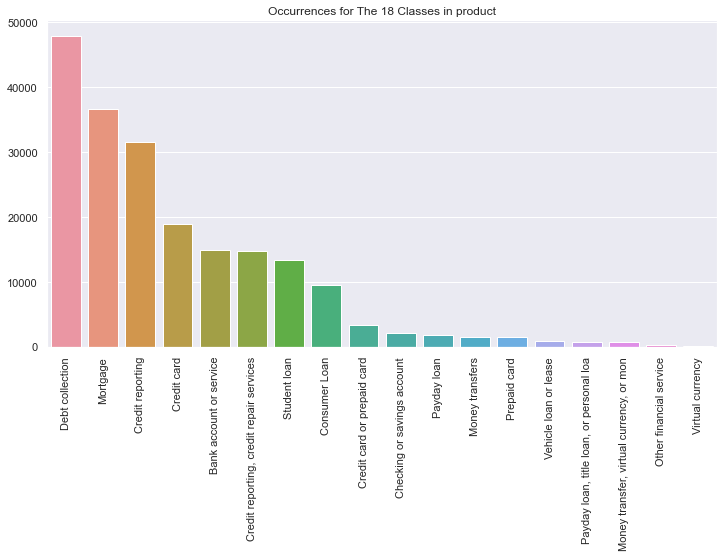

In [7]:
labels, counamts = frequencies(d, 'product')

Simplificamos o problema, considerando somente as 6 classes mais frequentes:

In [8]:
s = d['product'].isin(labels[:6])
d = d[s]

test_share = .3

d_train, d_test = train_test_split(d, test_size=test_share, shuffle=False)
assert d_train['date-received'].max() <= d_test['date-received'].min()

x_train, x_test = d_train['consumer-message'], d_test['consumer-message']
y_train, y_test = d_train['product'], d_test['product']

Vamos codificar as palavras na conversa utilizando o TF-IDF, gerando um vetor de características baseadas nas frequências de ocorrência das palavras no documento e em todo o conjunto de dados.

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

features = 1024

encoder = make_pipeline(TfidfVectorizer(min_df=5,
                                        stop_words='english',
                                        strip_accents='unicode',
                                        max_features=features),
                        StandardScaler(with_mean=False))

x_train = encoder.fit_transform(x_train)
x_test = encoder.transform(x_test)

label_enc = LabelEncoder()
ye_train = label_enc.fit_transform(y_train)
ye_test = label_enc.transform(y_test)

In [10]:
x_train

<115143x1024 sparse matrix of type '<class 'numpy.float64'>'
	with 4511657 stored elements in Compressed Sparse Row format>

## Treinando um regressor logístico para classificar produto
**Atividade (1 pt):** treine um regressor logístico, buscando os hiper-parâmetros com *grid-search*.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score

#### Saga

In [13]:
C = []
pots = range(-10,5,1)
for pot in pots:
    C.append(10**pot)
penalty = ["l2"]
solver = ["saga"]
parameters = {'C': C, 'penalty': penalty, 'solver':solver}
model = LogisticRegression(class_weight='balanced')
clf = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'accuracy', cv =5,  verbose = 3)
clf.fit(x_train, ye_train)
print(clf.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END ..C=1e-10, penalty=l2, solver=saga;, score=0.618 total time=   1.9s
[CV 2/5] END ..C=1e-10, penalty=l2, solver=saga;, score=0.541 total time=   2.1s
[CV 3/5] END ..C=1e-10, penalty=l2, solver=saga;, score=0.477 total time=   1.9s
[CV 4/5] END ..C=1e-10, penalty=l2, solver=saga;, score=0.465 total time=   2.0s
[CV 5/5] END ..C=1e-10, penalty=l2, solver=saga;, score=0.634 total time=   2.0s
[CV 1/5] END ..C=1e-09, penalty=l2, solver=saga;, score=0.685 total time=   2.2s
[CV 2/5] END ..C=1e-09, penalty=l2, solver=saga;, score=0.732 total time=   2.7s
[CV 3/5] END ..C=1e-09, penalty=l2, solver=saga;, score=0.713 total time=   2.1s
[CV 4/5] END ..C=1e-09, penalty=l2, solver=saga;, score=0.750 total time=   2.1s
[CV 5/5] END ..C=1e-09, penalty=l2, solver=saga;, score=0.600 total time=   2.1s
[CV 1/5] END ..C=1e-08, penalty=l2, solver=saga;, score=0.737 total time=   2.2s
[CV 2/5] END ..C=1e-08, penalty=l2, solver=saga;

C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ..C=1e-05, penalty=l2, solver=saga;, score=0.771 total time=  13.4s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ..C=1e-05, penalty=l2, solver=saga;, score=0.776 total time=  13.4s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..C=1e-05, penalty=l2, solver=saga;, score=0.764 total time=  13.4s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ..C=1e-05, penalty=l2, solver=saga;, score=0.770 total time=  13.3s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ..C=1e-05, penalty=l2, solver=saga;, score=0.764 total time=  13.6s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .C=0.0001, penalty=l2, solver=saga;, score=0.781 total time=  13.7s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .C=0.0001, penalty=l2, solver=saga;, score=0.793 total time=  13.9s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .C=0.0001, penalty=l2, solver=saga;, score=0.777 total time=  13.8s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .C=0.0001, penalty=l2, solver=saga;, score=0.780 total time=  13.6s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .C=0.0001, penalty=l2, solver=saga;, score=0.778 total time=  13.5s
[CV 1/5] END ..C=0.001, penalty=l2, solver=saga;, score=0.784 total time=   2.4s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ..C=0.001, penalty=l2, solver=saga;, score=0.796 total time=  13.4s
[CV 3/5] END ..C=0.001, penalty=l2, solver=saga;, score=0.781 total time=   2.9s
[CV 4/5] END ..C=0.001, penalty=l2, solver=saga;, score=0.783 total time=   2.5s
[CV 5/5] END ..C=0.001, penalty=l2, solver=saga;, score=0.778 total time=   2.6s
[CV 1/5] END ...C=0.01, penalty=l2, solver=saga;, score=0.784 total time=   9.6s
[CV 2/5] END ...C=0.01, penalty=l2, solver=saga;, score=0.793 total time=  12.2s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ...C=0.01, penalty=l2, solver=saga;, score=0.779 total time=  13.3s
[CV 4/5] END ...C=0.01, penalty=l2, solver=saga;, score=0.782 total time=   9.7s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ...C=0.01, penalty=l2, solver=saga;, score=0.777 total time=  13.2s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ....C=0.1, penalty=l2, solver=saga;, score=0.783 total time=  13.3s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ....C=0.1, penalty=l2, solver=saga;, score=0.792 total time=  13.3s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ....C=0.1, penalty=l2, solver=saga;, score=0.777 total time=  13.3s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ....C=0.1, penalty=l2, solver=saga;, score=0.782 total time=  13.2s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ....C=0.1, penalty=l2, solver=saga;, score=0.777 total time=  13.3s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ......C=1, penalty=l2, solver=saga;, score=0.783 total time=  13.3s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ......C=1, penalty=l2, solver=saga;, score=0.792 total time=  13.3s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ......C=1, penalty=l2, solver=saga;, score=0.778 total time=  13.3s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ......C=1, penalty=l2, solver=saga;, score=0.782 total time=  13.2s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ......C=1, penalty=l2, solver=saga;, score=0.776 total time=  13.3s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END .....C=10, penalty=l2, solver=saga;, score=0.783 total time=  13.4s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END .....C=10, penalty=l2, solver=saga;, score=0.792 total time=  13.3s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END .....C=10, penalty=l2, solver=saga;, score=0.778 total time=  13.3s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END .....C=10, penalty=l2, solver=saga;, score=0.782 total time=  13.3s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END .....C=10, penalty=l2, solver=saga;, score=0.776 total time=  13.2s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ....C=100, penalty=l2, solver=saga;, score=0.783 total time=  13.3s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ....C=100, penalty=l2, solver=saga;, score=0.792 total time=  13.3s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ....C=100, penalty=l2, solver=saga;, score=0.778 total time=  13.3s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ....C=100, penalty=l2, solver=saga;, score=0.782 total time=  13.2s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ....C=100, penalty=l2, solver=saga;, score=0.776 total time=  13.2s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ...C=1000, penalty=l2, solver=saga;, score=0.783 total time=  13.3s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ...C=1000, penalty=l2, solver=saga;, score=0.792 total time=  13.3s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ...C=1000, penalty=l2, solver=saga;, score=0.778 total time=  13.3s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ...C=1000, penalty=l2, solver=saga;, score=0.782 total time=  13.2s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ...C=1000, penalty=l2, solver=saga;, score=0.776 total time=  13.3s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ..C=10000, penalty=l2, solver=saga;, score=0.783 total time=  13.2s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ..C=10000, penalty=l2, solver=saga;, score=0.792 total time=  13.3s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..C=10000, penalty=l2, solver=saga;, score=0.778 total time=  13.3s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ..C=10000, penalty=l2, solver=saga;, score=0.782 total time=  13.2s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ..C=10000, penalty=l2, solver=saga;, score=0.776 total time=  13.2s
{'C': 0.001, 'penalty': 'l2', 'solver': 'saga'}


In [14]:
df_lr_results = pd.DataFrame(clf.cv_results_)
df_lr_results.sort_values('mean_test_score', ascending = False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,4.847415,4.304285,0.006981,0.000001,0.001,l2,saga,"{'C': 0.001, 'penalty': 'l2', 'solver': 'saga'}",0.783534,0.796474,0.780798,0.783134,0.778487,0.784485,0.006262,1
8,11.694973,1.654774,0.006980,0.000001,0.01,l2,saga,"{'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}",0.783664,0.793174,0.778584,0.782178,0.777315,0.782983,0.005594,2
9,13.366673,0.046659,0.006780,0.000398,0.1,l2,saga,"{'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}",0.782969,0.792436,0.777368,0.782308,0.776620,0.782340,0.005653,3
10,13.355705,0.009647,0.006986,0.000012,1,l2,saga,"{'C': 1, 'penalty': 'l2', 'solver': 'saga'}",0.782752,0.792436,0.777628,0.782308,0.776229,0.782271,0.005685,4
14,13.333455,0.024342,0.006986,0.000013,10000,l2,saga,"{'C': 10000, 'penalty': 'l2', 'solver': 'saga'}",0.782665,0.792479,0.777541,0.782178,0.776186,0.782210,0.005723,5
11,13.398281,0.065721,0.006991,0.000015,10,l2,saga,"{'C': 10, 'penalty': 'l2', 'solver': 'saga'}",0.782622,0.792392,0.777541,0.782222,0.776186,0.782193,0.005691,6
13,13.360283,0.033995,0.006781,0.000399,1000,l2,saga,"{'C': 1000, 'penalty': 'l2', 'solver': 'saga'}",0.782665,0.792349,0.777541,0.782222,0.776186,0.782193,0.005676,6
12,13.347924,0.053334,0.006987,0.000011,100,l2,saga,"{'C': 100, 'penalty': 'l2', 'solver': 'saga'}",0.782622,0.792262,0.777585,0.782222,0.776186,0.782175,0.005637,8
6,13.807088,0.131881,0.007585,0.001208,0.0001,l2,saga,"{'C': 0.0001, 'penalty': 'l2', 'solver': 'saga'}",0.780538,0.793087,0.777151,0.780354,0.777619,0.781750,0.005834,9
5,13.505079,0.103661,0.007175,0.000386,0.00001,l2,saga,"{'C': 1e-05, 'penalty': 'l2', 'solver': 'saga'}",0.770637,0.776499,0.763689,0.770063,0.764113,0.769000,0.004736,10


#### lbfgs

In [16]:
C = []
pots = range(-10,5,1)
for pot in pots:
    C.append(10**pot)
penalty = ["l2"]
solver = ["lbfgs"]
parameters = {'C': C, 'penalty': penalty, 'solver':solver}
model = LogisticRegression(class_weight='balanced')
clf = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'accuracy', cv =5,  verbose = 3)
clf.fit(x_train, ye_train)
print(clf.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END .C=1e-10, penalty=l2, solver=lbfgs;, score=0.696 total time=   0.4s
[CV 2/5] END .C=1e-10, penalty=l2, solver=lbfgs;, score=0.699 total time=   0.2s
[CV 3/5] END .C=1e-10, penalty=l2, solver=lbfgs;, score=0.692 total time=   0.2s
[CV 4/5] END .C=1e-10, penalty=l2, solver=lbfgs;, score=0.703 total time=   0.2s
[CV 5/5] END .C=1e-10, penalty=l2, solver=lbfgs;, score=0.689 total time=   0.2s
[CV 1/5] END .C=1e-09, penalty=l2, solver=lbfgs;, score=0.696 total time=   0.2s
[CV 2/5] END .C=1e-09, penalty=l2, solver=lbfgs;, score=0.699 total time=   0.2s
[CV 3/5] END .C=1e-09, penalty=l2, solver=lbfgs;, score=0.692 total time=   0.2s
[CV 4/5] END .C=1e-09, penalty=l2, solver=lbfgs;, score=0.703 total time=   0.2s
[CV 5/5] END .C=1e-09, penalty=l2, solver=lbfgs;, score=0.689 total time=   0.2s
[CV 1/5] END .C=1e-08, penalty=l2, solver=lbfgs;, score=0.697 total time=   0.2s
[CV 2/5] END .C=1e-08, penalty=l2, solver=lbfgs;

C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END .C=0.001, penalty=l2, solver=lbfgs;, score=0.786 total time=   6.3s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END .C=0.001, penalty=l2, solver=lbfgs;, score=0.798 total time=   6.1s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END .C=0.001, penalty=l2, solver=lbfgs;, score=0.784 total time=   6.1s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END .C=0.001, penalty=l2, solver=lbfgs;, score=0.787 total time=   6.2s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END .C=0.001, penalty=l2, solver=lbfgs;, score=0.781 total time=   6.1s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ..C=0.01, penalty=l2, solver=lbfgs;, score=0.786 total time=   6.3s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ..C=0.01, penalty=l2, solver=lbfgs;, score=0.796 total time=   6.2s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ..C=0.01, penalty=l2, solver=lbfgs;, score=0.781 total time=   6.1s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ..C=0.01, penalty=l2, solver=lbfgs;, score=0.785 total time=   6.3s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ..C=0.01, penalty=l2, solver=lbfgs;, score=0.779 total time=   6.2s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ...C=0.1, penalty=l2, solver=lbfgs;, score=0.785 total time=   6.1s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ...C=0.1, penalty=l2, solver=lbfgs;, score=0.795 total time=   6.0s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ...C=0.1, penalty=l2, solver=lbfgs;, score=0.780 total time=   5.9s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ...C=0.1, penalty=l2, solver=lbfgs;, score=0.784 total time=   6.4s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ...C=0.1, penalty=l2, solver=lbfgs;, score=0.778 total time=   6.2s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END .....C=1, penalty=l2, solver=lbfgs;, score=0.785 total time=   6.3s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END .....C=1, penalty=l2, solver=lbfgs;, score=0.795 total time=   6.3s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END .....C=1, penalty=l2, solver=lbfgs;, score=0.780 total time=   5.9s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END .....C=1, penalty=l2, solver=lbfgs;, score=0.784 total time=   6.2s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END .....C=1, penalty=l2, solver=lbfgs;, score=0.777 total time=   6.1s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ....C=10, penalty=l2, solver=lbfgs;, score=0.785 total time=   6.4s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ....C=10, penalty=l2, solver=lbfgs;, score=0.795 total time=   6.1s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ....C=10, penalty=l2, solver=lbfgs;, score=0.779 total time=   6.1s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ....C=10, penalty=l2, solver=lbfgs;, score=0.784 total time=   5.9s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ....C=10, penalty=l2, solver=lbfgs;, score=0.777 total time=   6.1s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ...C=100, penalty=l2, solver=lbfgs;, score=0.785 total time=   6.1s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ...C=100, penalty=l2, solver=lbfgs;, score=0.795 total time=   6.2s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ...C=100, penalty=l2, solver=lbfgs;, score=0.779 total time=   6.0s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ...C=100, penalty=l2, solver=lbfgs;, score=0.784 total time=   6.0s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ...C=100, penalty=l2, solver=lbfgs;, score=0.777 total time=   5.9s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ..C=1000, penalty=l2, solver=lbfgs;, score=0.785 total time=   6.1s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ..C=1000, penalty=l2, solver=lbfgs;, score=0.795 total time=   6.3s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ..C=1000, penalty=l2, solver=lbfgs;, score=0.779 total time=   5.9s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ..C=1000, penalty=l2, solver=lbfgs;, score=0.784 total time=   6.1s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ..C=1000, penalty=l2, solver=lbfgs;, score=0.778 total time=   6.0s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END .C=10000, penalty=l2, solver=lbfgs;, score=0.785 total time=   6.2s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END .C=10000, penalty=l2, solver=lbfgs;, score=0.796 total time=   6.4s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END .C=10000, penalty=l2, solver=lbfgs;, score=0.779 total time=   5.9s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END .C=10000, penalty=l2, solver=lbfgs;, score=0.784 total time=   6.0s


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END .C=10000, penalty=l2, solver=lbfgs;, score=0.777 total time=   6.1s
{'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}


C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
df_lr_results_02 = pd.DataFrame(clf.cv_results_)
df_lr_results_02.sort_values('mean_test_score', ascending = False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,6.243707,0.069406,0.006981,1.507891e-07,0.001,l2,lbfgs,"{'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}",0.785792,0.798168,0.784055,0.787346,0.781136,0.787299,0.005812,1
8,6.312323,0.097002,0.007181,3.993275e-04,0.01,l2,lbfgs,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}",0.786096,0.796387,0.780755,0.785348,0.779008,0.785519,0.006059,2
9,6.207404,0.162449,0.006981,2.336015e-07,0.1,l2,lbfgs,"{'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.785314,0.795258,0.779626,0.784480,0.778357,0.784607,0.005964,3
14,6.237124,0.168799,0.006981,1.907349e-07,10000,l2,lbfgs,"{'C': 10000, 'penalty': 'l2', 'solver': 'lbfgs'}",0.784750,0.795519,0.779191,0.784349,0.777401,0.784242,0.006320,4
11,6.213289,0.137154,0.007181,3.994944e-04,10,l2,lbfgs,"{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}",0.784706,0.795302,0.779365,0.784219,0.777488,0.784216,0.006196,5
10,6.248095,0.135312,0.007181,3.988985e-04,1,l2,lbfgs,"{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.784967,0.794998,0.779539,0.784089,0.777488,0.784216,0.006066,6
13,6.187058,0.127118,0.007181,3.990889e-04,1000,l2,lbfgs,"{'C': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}",0.784576,0.795084,0.779061,0.784349,0.777705,0.784155,0.006119,7
12,6.129612,0.098624,0.006981,3.015783e-07,100,l2,lbfgs,"{'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}",0.784706,0.795171,0.778844,0.784219,0.777488,0.784086,0.006234,8
6,3.771118,0.073415,0.006981,1.348699e-06,0.0001,l2,lbfgs,"{'C': 0.0001, 'penalty': 'l2', 'solver': 'lbfgs'}",0.783490,0.794563,0.778453,0.782612,0.778617,0.783547,0.005873,9
5,1.571000,0.059545,0.007181,3.990412e-04,0.00001,l2,lbfgs,"{'C': 1e-05, 'penalty': 'l2', 'solver': 'lbfgs'}",0.772417,0.777194,0.766121,0.770931,0.766589,0.770650,0.004075,10


#### newton-cf

In [21]:
C = []
pots = range(-10,1,1)
for pot in pots:
    C.append(10**pot)
penalty = ["l2"]
solver = ["newton-cg"]
parameters = {'C': C, 'penalty': penalty, 'solver':solver}
model = LogisticRegression(class_weight='balanced')
clf = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'accuracy', cv =5,  verbose = 3, n_jobs= -1)
clf.fit(x_train, ye_train)
print(clf.best_params_)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
{'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}


In [22]:
df_lr_results_03 = pd.DataFrame(clf.cv_results_)
df_lr_results_03.sort_values('mean_test_score', ascending = False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,16.138576,0.300236,0.008178,0.000399,0.001,l2,newton-cg,"{'C': 0.001, 'penalty': 'l2', 'solver': 'newto...",0.785705,0.798211,0.784011,0.787302,0.781179,0.787282,0.005829,1
8,18.647546,0.767426,0.009375,0.002863,0.01,l2,newton-cg,"{'C': 0.01, 'penalty': 'l2', 'solver': 'newton...",0.786009,0.796431,0.780494,0.785565,0.779095,0.785519,0.006096,2
9,36.220287,2.456868,0.008678,0.000871,0.1,l2,newton-cg,"{'C': 0.1, 'penalty': 'l2', 'solver': 'newton-...",0.785314,0.794650,0.779452,0.784653,0.778183,0.784451,0.005815,3
10,76.393002,9.136396,0.007785,0.000387,1,l2,newton-cg,"{'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}",0.785227,0.794650,0.779452,0.784263,0.777705,0.784260,0.005916,4
6,12.245782,1.234098,0.008378,0.001197,0.0001,l2,newton-cg,"{'C': 0.0001, 'penalty': 'l2', 'solver': 'newt...",0.783447,0.794563,0.778410,0.782612,0.778617,0.783530,0.005881,5
5,10.103817,2.613720,0.008775,0.000976,0.00001,l2,newton-cg,"{'C': 1e-05, 'penalty': 'l2', 'solver': 'newto...",0.772461,0.777237,0.766164,0.770974,0.766589,0.770685,0.004084,6
4,6.165497,2.679587,0.008590,0.001019,0.000001,l2,newton-cg,"{'C': 1e-06, 'penalty': 'l2', 'solver': 'newto...",0.755439,0.757263,0.751704,0.761377,0.755385,0.756234,0.003143,7
3,2.253374,0.029764,0.008577,0.000798,0.0,l2,newton-cg,"{'C': 1e-07, 'penalty': 'l2', 'solver': 'newto...",0.750054,0.751096,0.746059,0.756688,0.750955,0.750971,0.003396,8
2,5.512860,2.261867,0.008179,0.000747,0.0,l2,newton-cg,"{'C': 1e-08, 'penalty': 'l2', 'solver': 'newto...",0.749316,0.750445,0.745538,0.755819,0.750130,0.750250,0.003291,9
1,1.922260,0.013684,0.007580,0.000488,0.0,l2,newton-cg,"{'C': 1e-09, 'penalty': 'l2', 'solver': 'newto...",0.749316,0.750532,0.745495,0.755732,0.750087,0.750232,0.003275,10


In [23]:
clf_bp_saga = LogisticRegression(C= 0.001, solver ='saga',class_weight = 'balanced')
clf_bp_lbfgs = LogisticRegression(C= 0.001, solver = 'lbfgs',class_weight = 'balanced')
clf_bp_newton_cg = LogisticRegression(C= 0.001,solver = 'newton-cg', class_weight = 'balanced')
lst_clfs = [clf_bp_saga,clf_bp_lbfgs, clf_bp_newton_cg ]

for clf in lst_clfs:
    clf.fit(x_train, ye_train)    

C:\Users\home41_hs\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Iremos calcular a matriz de confusão relativa $R$, que guarda porcentagens de incidências em vez das contagens absolutas, e plotar o heatmap dessa matriz. Além disso, iremos calcular a distribuição de confiança nas predições por classe (mais próximos de `1.0` --> mais confiante):

In [35]:
def evaluate(y, p, probabilities, labels=None, save = False, save_name = 'test' ):
    # Cálculo das métricas de acerto.
    print('Accuracy:', metrics.accuracy_score(y, p).round(3))
    print('Accuracy (balanced):', metrics.balanced_accuracy_score(y, p).round(3))
    
    # Calculo da matriz de confusão.
    c = metrics.confusion_matrix(y, p)
    r = c / c.sum(axis=1, keepdims=True)
    
    # Impressão dos gráficos.
    (plt.figure(figsize=(16, 12))
     .suptitle('Matriz de confusão', fontsize=20))
    sns.heatmap(r,
                cmap="YlGnBu", linewidths=.5, annot=True, fmt=".1%",
                xticklabels=labels, yticklabels=labels, cbar=False)
    plt.tight_layout()
    if save == True:
        plt.savefig('{}.png'.format(save_name), dpi = 300)

    (plt.figure(figsize=(16, 12))
     .suptitle('Distribuição de confiança para cada classe', fontsize=20))
    
    for i in np.unique(y):
        # Para cada classe `i`, seleciona suas amostras e filtra a confiança
        # do modelo em predizer estas amostras como sendo da classe `i`.
        sns.distplot(probabilities[y.ravel() == i][:, i],
                     hist=False,
                     label=labels[i])
    plt.legend()
    

Vamos utilizar a função `evaluate` para avaliar o modelo treinado anteriormente:

#### saga

In [32]:
ls

 O volume na unidade C nÃ£o tem nome.
 O NÃºmero de SÃ©rie do Volume Ã© A67B-066F

 Pasta de C:\Users\home41_hs\Desktop\Unicamp\INF-0616-010 - Supervisionado 2\Teste 3

17/10/2021  21:32    <DIR>          .
17/10/2021  21:32    <DIR>          ..
17/10/2021  18:38    <DIR>          .ipynb_checkpoints
03/10/2020  12:07    <DIR>          __MACOSX
17/10/2021  21:32           823.631 assignment-3.ipynb
17/10/2021  18:34             5.148 assignment-3.ipynb.zip
03/12/2018  14:32       241.600.449 customer-issues.csv
               3 arquivo(s)    242.429.228 bytes
               4 pasta(s)   170.734.903.296 bytes disponÃ­veis


Accuracy: 0.754
Accuracy (balanced): 0.749


C:\Users\home41_hs\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\home41_hs\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\home41_hs\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

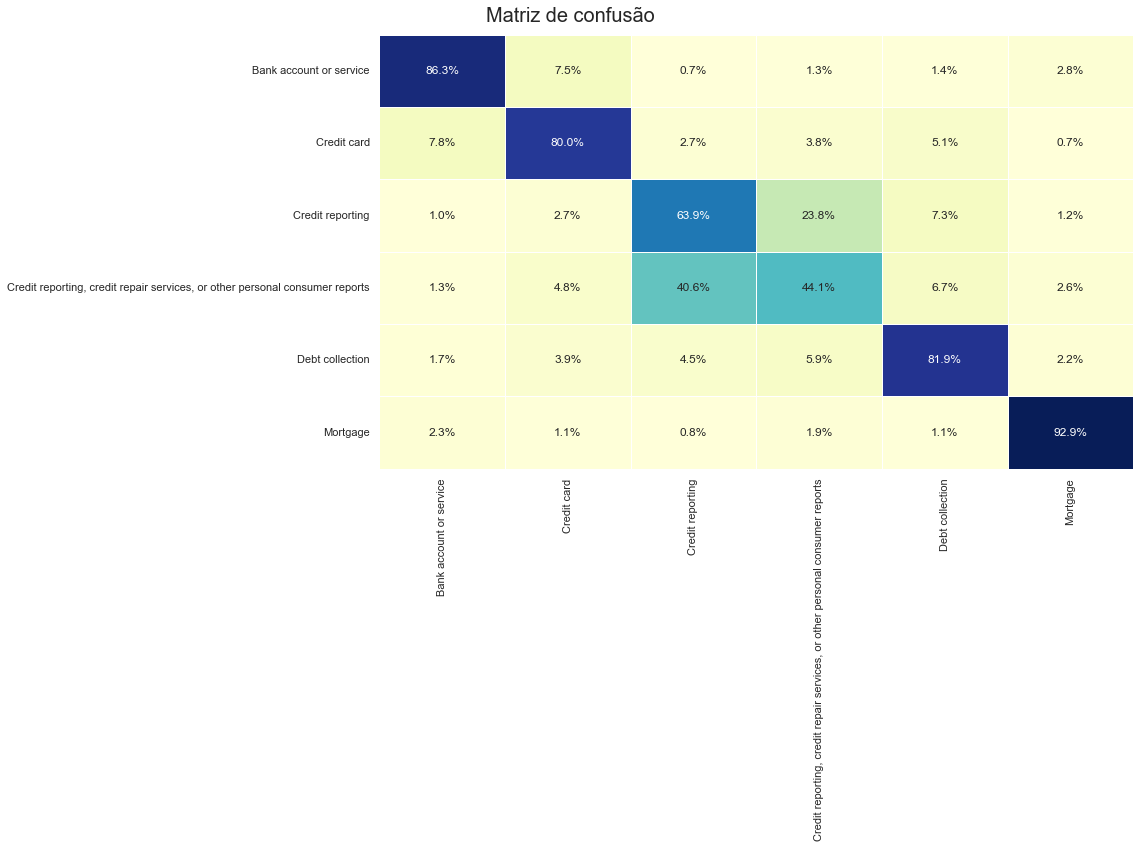

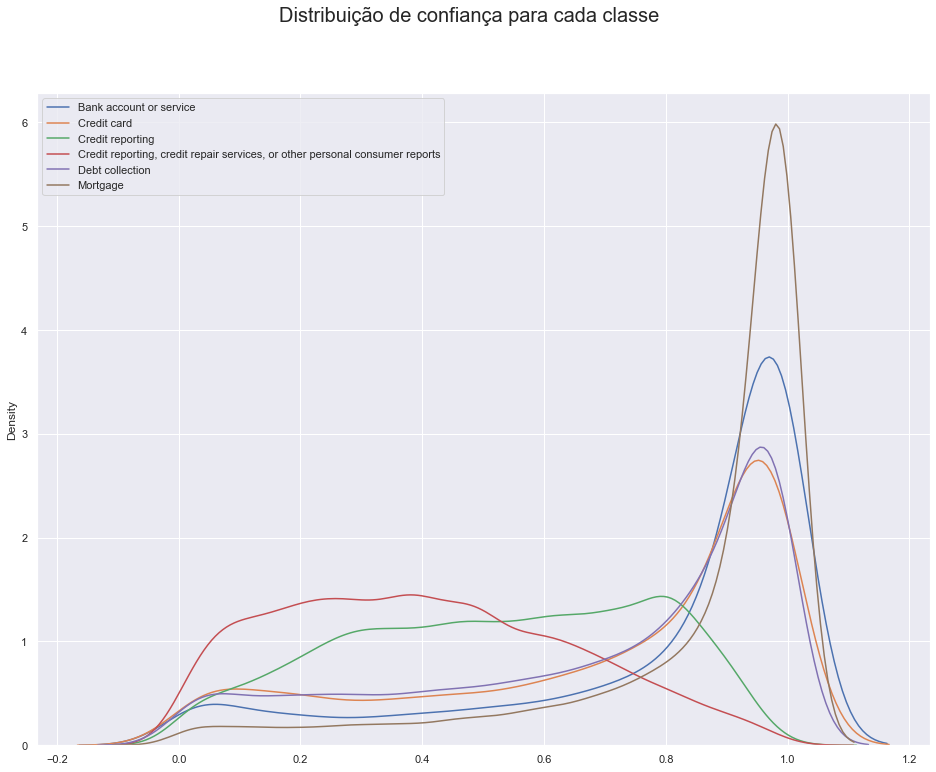

In [36]:
evaluate(ye_test, clf_bp_saga.predict(x_test), clf_bp_saga.predict_proba(x_test), labels=label_enc.classes_, save = True, save_name='saga_clf')

#### lbfgs

Accuracy: 0.754
Accuracy (balanced): 0.748


C:\Users\home41_hs\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\home41_hs\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\home41_hs\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

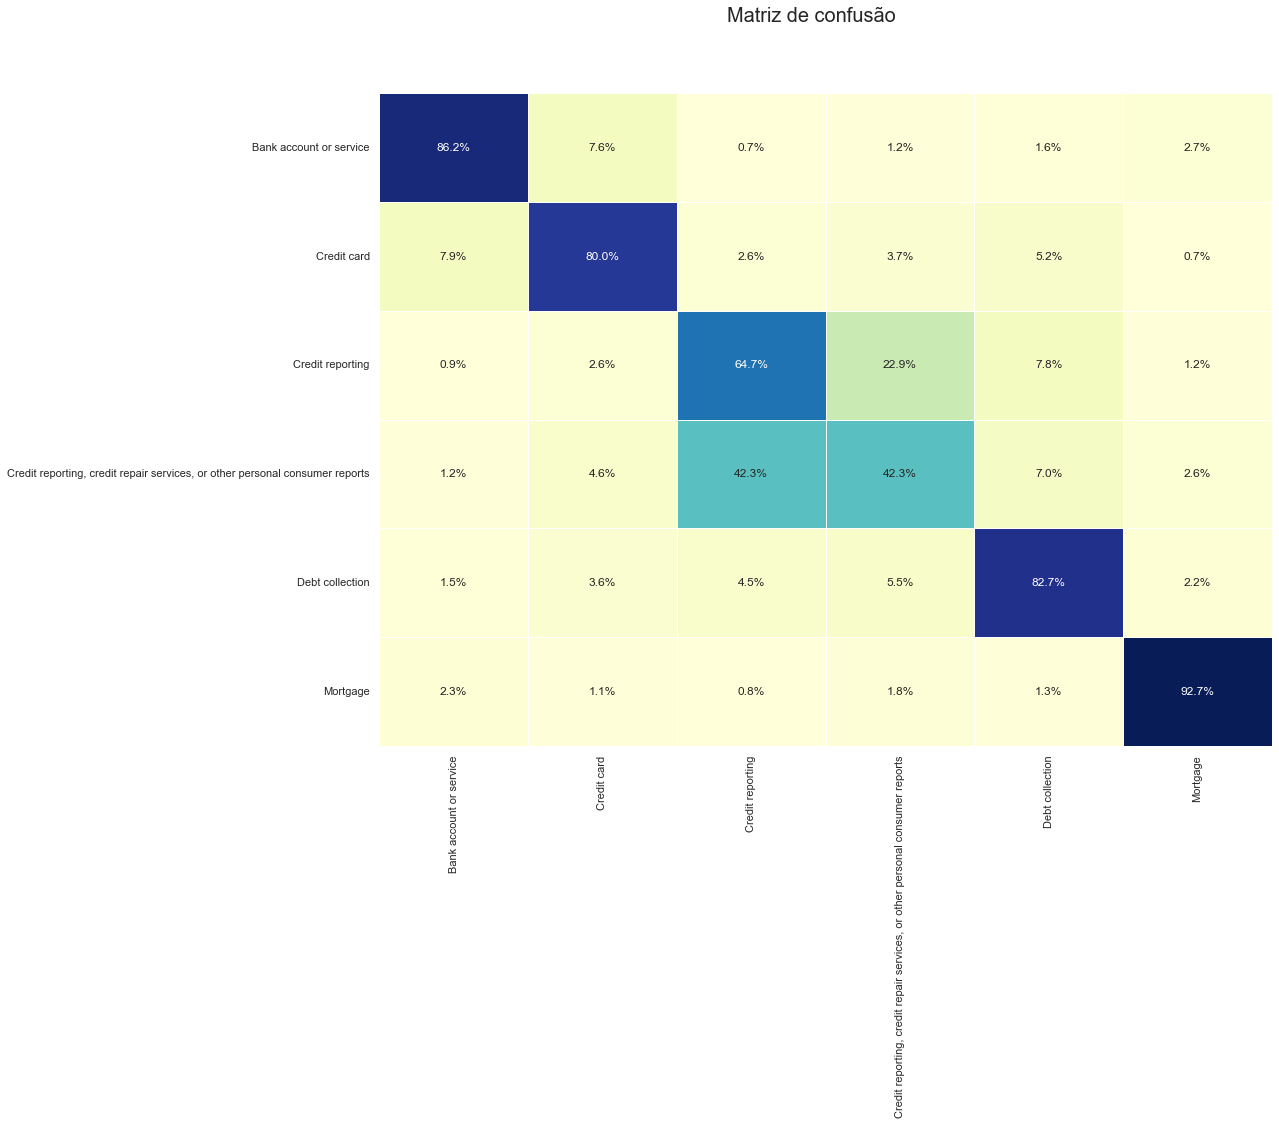

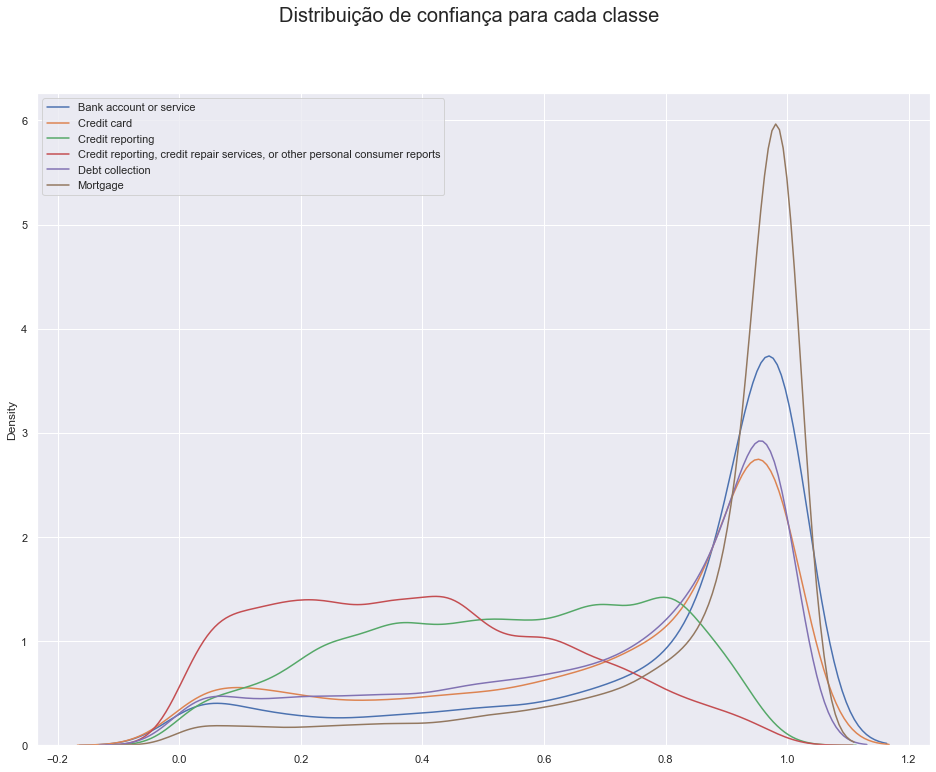

In [27]:
evaluate(ye_test, clf_bp_lbfgs.predict(x_test), clf_bp_lbfgs.predict_proba(x_test), labels=label_enc.classes_)

#### newton-cg

Accuracy: 0.754
Accuracy (balanced): 0.748


C:\Users\home41_hs\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\home41_hs\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\home41_hs\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

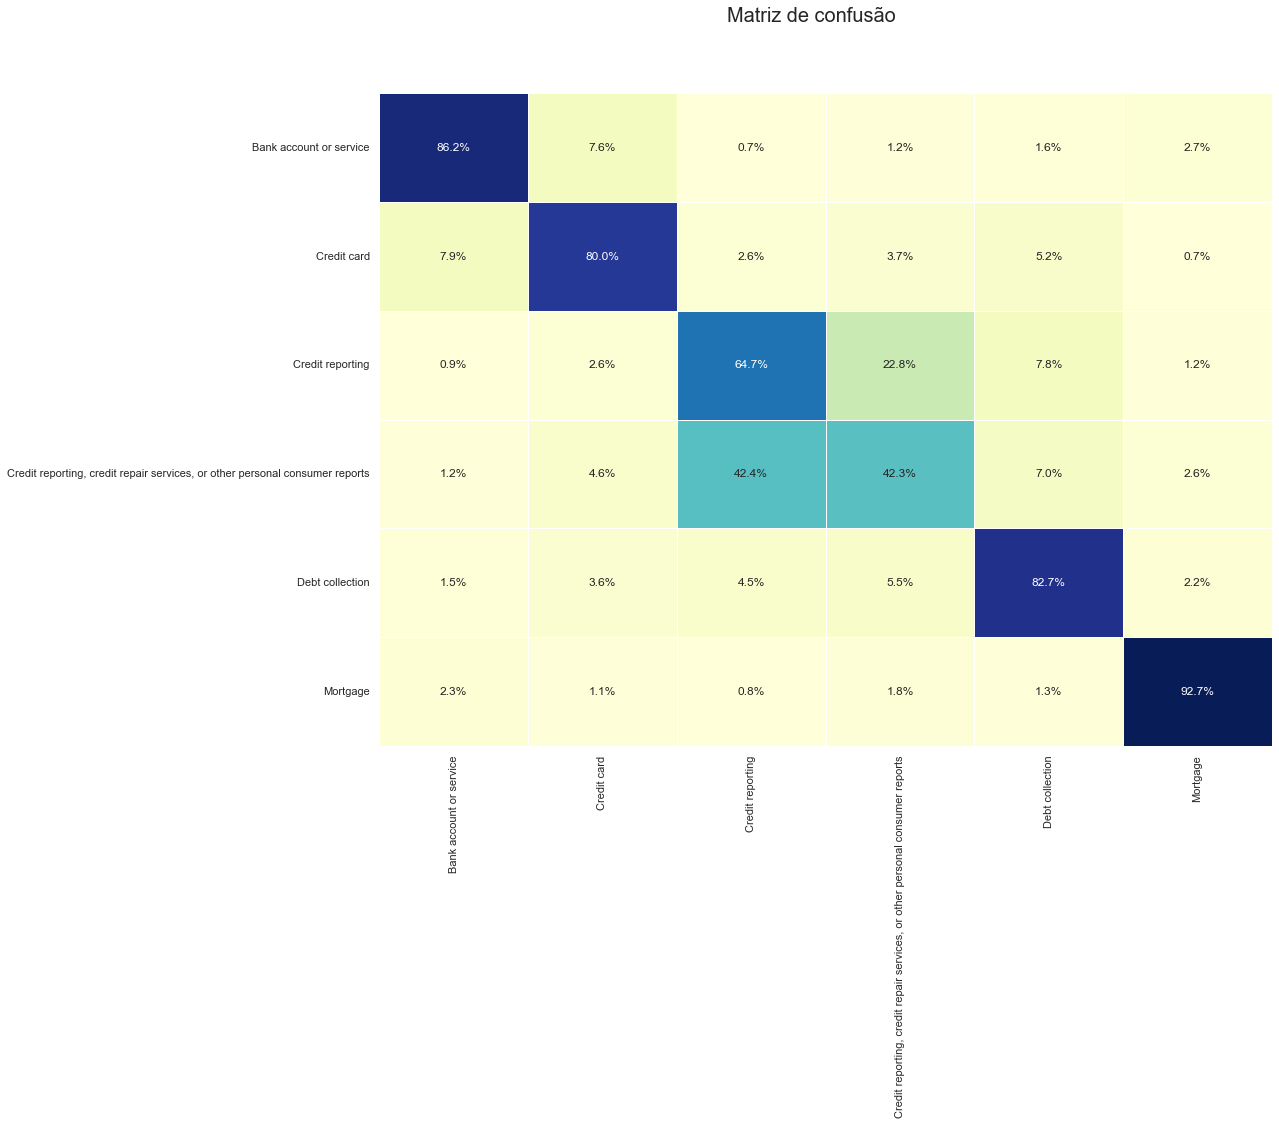

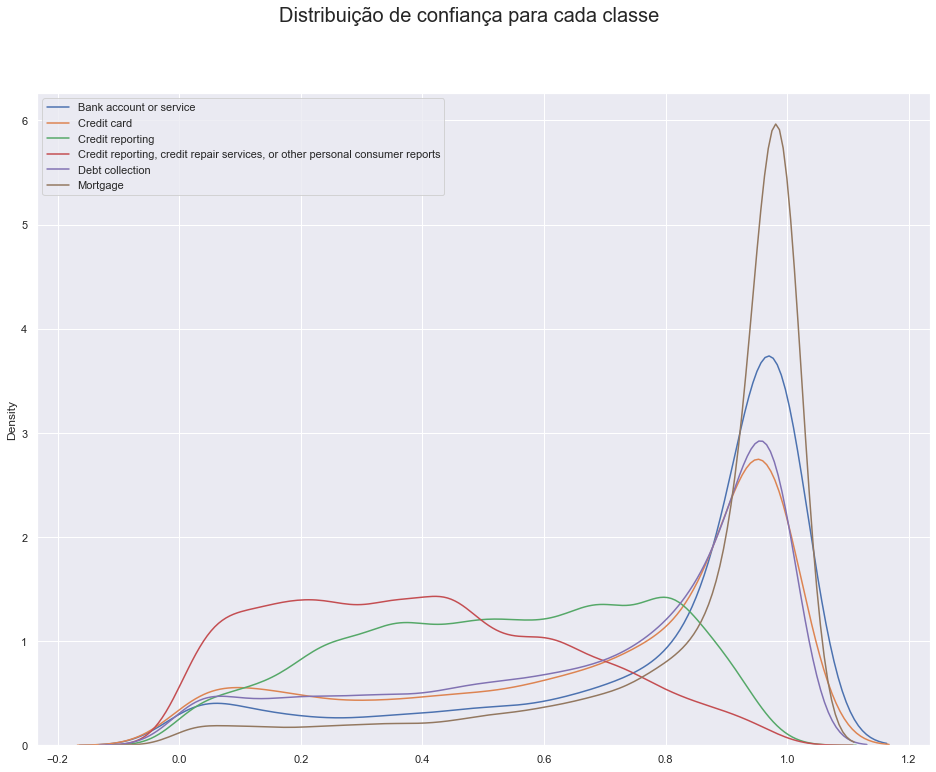

In [28]:
evaluate(ye_test, clf_bp_newton_cg.predict(x_test), clf_bp_newton_cg.predict_proba(x_test), labels=label_enc.classes_)

**Pergunta (1pt):** considerando o gráfico de distribuição de confiança para o seu modelo treinado, as amostras são classificadas com alta confiança? Há uma grande diferença de confiança entre as diferentes classes?

Existem 2 features que não tem boa confiança a "CREDIT REPORTING" e a "CREDIT REPORTING, CREDIT REPARI SERVICES, OR OTHER PERSONAL CONSUMER REPORTS",  já pelo nome pode-se dizer que podem apresentar características semelhantes 

----------
----------

## Redes Neurais
Iremos treinar alguns modelos de redes neurais, variando número de camadas e quantidade de neurônios em cada camada.

In [140]:

from keras.utils import np_utils

In [175]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Dropout

In [173]:
epochs = 10
batch_size = 128
input_shape = [features]

Vamos converter os rótulos em vetores *One Hot Encoded*:

In [141]:
y_ohe_train = np_utils.to_categorical(ye_train, num_classes=6)
y_ohe_test = np_utils.to_categorical(ye_test, num_classes=6)

In [150]:
y_ohe_test

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

**Atividade (1 pt):** defina uma arquitetura de uma rede neural capaz de classificar os diferentes produtos a partir da conversa dos clientes. Compile a sua rede com a loss `categorical_crossentropy`, optimizador `SGD` e defina as métricas relevantes para o problema. 

In [49]:
#input x
x_train.shape[1]

1024

In [50]:
#output y 
len(y_ohe_test[0])

6

#### tf Model

In [82]:
#creating a model
model = tf.keras.Sequential()

#definning layers
#first layer
model.add(Dense(512, activation = 'relu', input_shape = (x_train.shape[1],)))
#hidden layers
#1
model.add(Dense(256,activation='relu'))
#2
model.add(Dense(64,activation='relu'))
# output
model.add(Dense(6, activation='softmax'))

#model setup 
optimizer_m = tf.keras.optimizers.SGD(lr=0.01)
loss_m = "categorical_crossentropy"
metrics_m = ['accuracy']

#model compiling
model.compile(optimizer = optimizer_m, loss = loss_m, metrics= metrics_m)



In [83]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_61 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_62 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_63 (Dense)             (None, 6)                 390       
Total params: 672,966
Trainable params: 672,966
Non-trainable params: 0
_________________________________________________________________


### Treinando a rede neural

**Atividade (1 pt):** treine o modelo definido acima sobre o conjunto, respeitando as seguintes regras:

1. Separe um subconjunto do treino para validação.
2. Utilize alguma técnica para conservar os parâmetros que melhor generalizam o problema, como `ModelCheckpoint` (salve o modelo com nome de `weights.h5`).

In [85]:
import time
from keras.callbacks import ModelCheckpoint

In [89]:
start = time.time()

filepath="weights.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(x_train.toarray(), y_ohe_train, validation_data=(x_test.toarray(), y_ohe_test), 
         epochs = epochs, 
         batch_size = batch_size, callbacks=callbacks_list)
end = time.time()
print('elapsed : {}'.format(end-start))

Epoch 1/10
900/900 [==============================] - 3s 3ms/step - loss: 0.3869 - accuracy: 0.8710 - val_loss: 0.7151 - val_accuracy: 0.7486

Epoch 00001: val_accuracy improved from -inf to 0.74860, saving model to weights.h5
Epoch 2/10
900/900 [==============================] - 3s 3ms/step - loss: 0.3630 - accuracy: 0.8798 - val_loss: 0.7196 - val_accuracy: 0.7482

Epoch 00002: val_accuracy did not improve from 0.74860
Epoch 3/10
900/900 [==============================] - 3s 3ms/step - loss: 0.3393 - accuracy: 0.8884 - val_loss: 0.7316 - val_accuracy: 0.7479

Epoch 00003: val_accuracy did not improve from 0.74860
Epoch 4/10
900/900 [==============================] - 3s 3ms/step - loss: 0.3156 - accuracy: 0.8974 - val_loss: 0.7937 - val_accuracy: 0.7435

Epoch 00004: val_accuracy did not improve from 0.74860
Epoch 5/10
900/900 [==============================] - 3s 3ms/step - loss: 0.2913 - accuracy: 0.9067 - val_loss: 0.7841 - val_accuracy: 0.7458

Epoch 00005: val_accuracy did not im

In [90]:
model.load_weights('weights.h5')

O método `model.fit` retorna `model.history`, e contem algumas informações interessantes a respeito do histórico de treinamento.

**Atividade (1 pt):** plote um gráfico de linhas exibindo a evolução dos valores da função *loss* sobre o conjunto de treino e validação. A partir de qual `epoch` a rede começou a super-especializar?

a partir da segunda epoch

In [91]:
def plot_history (history):
    plt.figure(figsize = (12,4))
    plt.plot(history.history["accuracy"], label = 'Train Accuracy')
    plt.plot(history.history["val_accuracy"], label = 'Test Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc ='lower right')
    plt.title('Accuracy eval')
    plt.show()

    plt.figure(figsize = (12,4))
    plt.plot(history.history["loss"], label = 'Train Error')
    plt.plot(history.history["val_loss"], label = 'Test Error')
    plt.ylabel('Error')
    plt.xlabel('Epoch')
    plt.legend(loc ='lower right')
    plt.title('Error eval')
    plt.show()

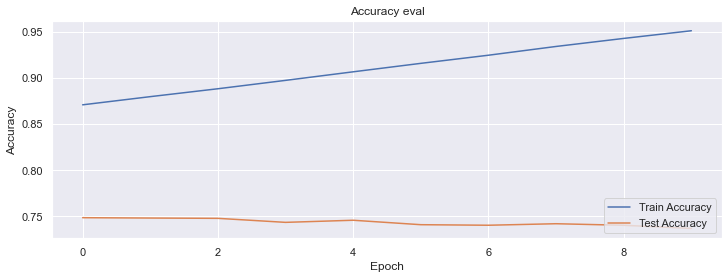

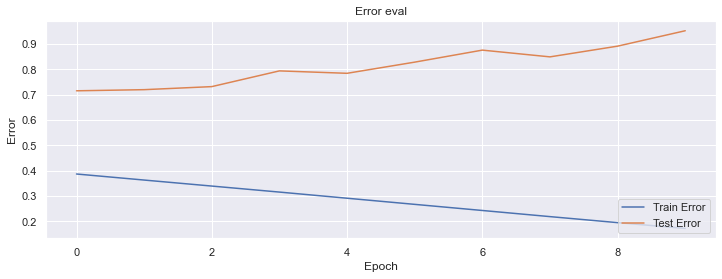

In [92]:
plot_history(history)

### Avaliando o modelo treinado

**Atividade (1 pt):** teste o modelo treinado utilizando o subconjunto de teste. Reporte a acurácia para cada classe e a matriz de confusão percentual (usando a função `evaluate` definida anteriormente).

In [165]:
prob_predictions = model.predict(x_test.toarray())
enc_predictions = np.argmax(predictions, axis = 1)

Accuracy: 0.749
Accuracy (balanced): 0.724


C:\Users\home41_hs\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\home41_hs\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\home41_hs\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

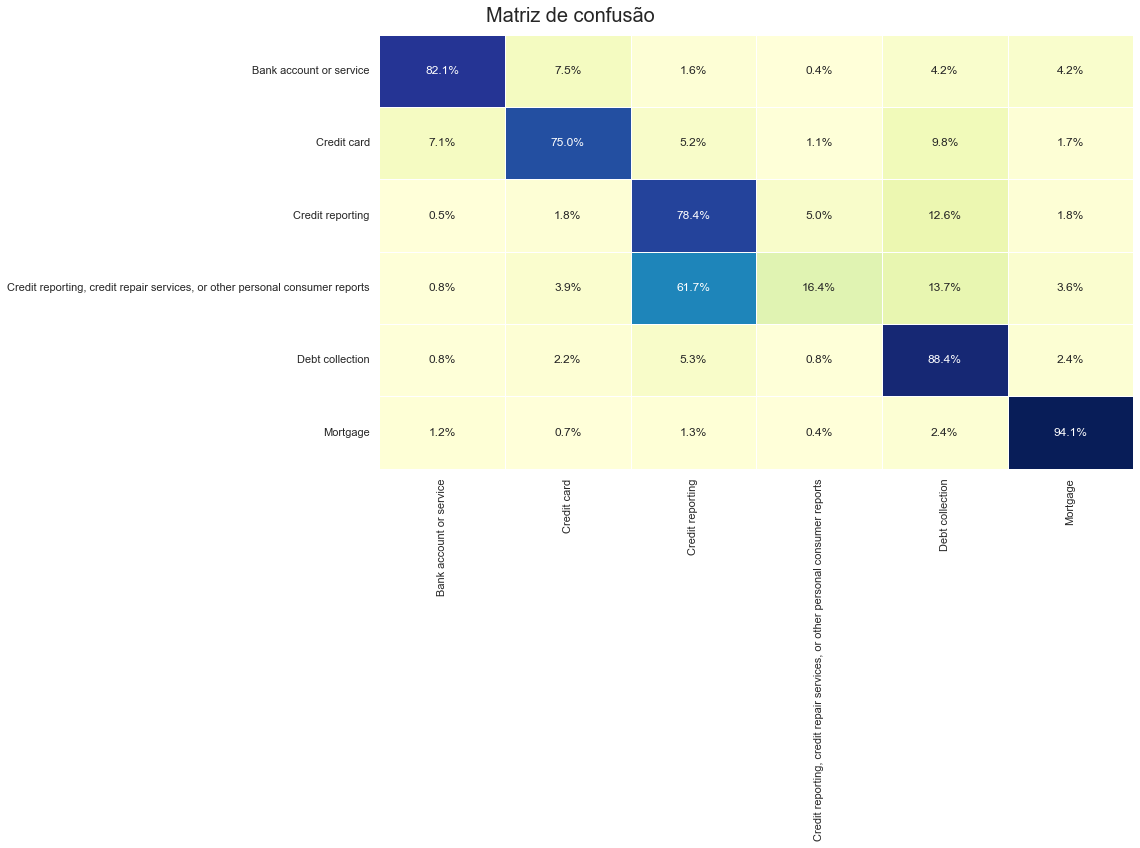

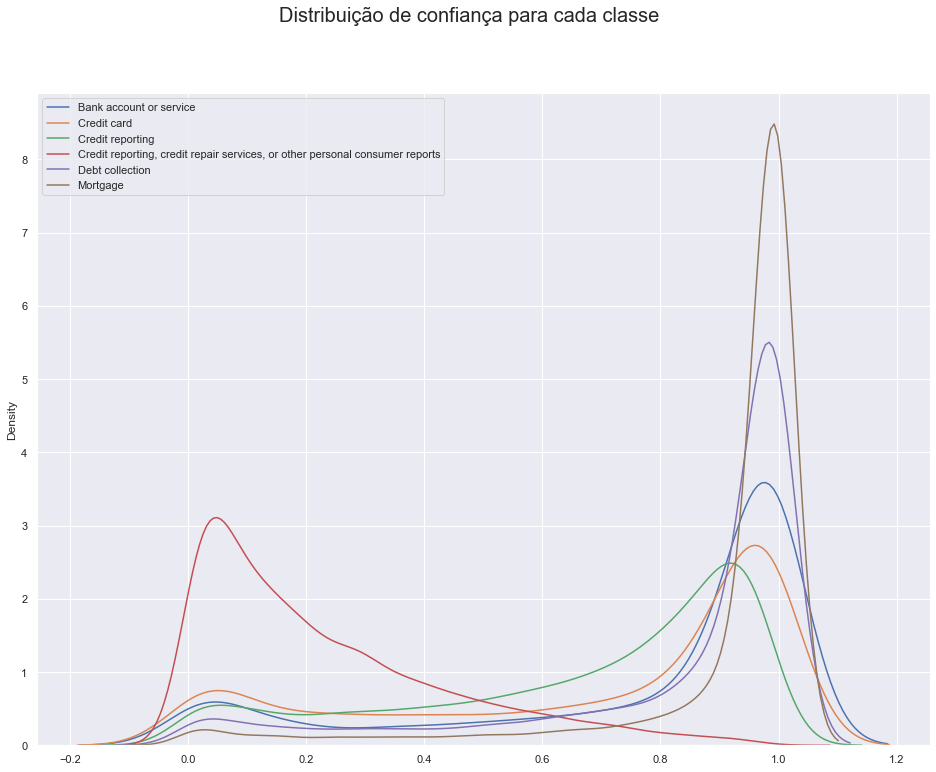

In [167]:
evaluate(ye_test, enc_predictions ,prob_predictions, labels=label_enc.classes_, save = True, save_name='NN_1_layer')

--------

Repita agora a definição, treinamento e avaliação de uma rede neural mais complexa, aumentando o número de camadas ou a quantidade de neurônios nas camadas da rede anterior:

**Atividade (1 pt):** defina uma rede neural mais complexa e a compile com as mesmas configurações da rede anterior.

In [169]:
#creating a model
model = tf.keras.Sequential()

#definning layers
#first layer
model.add(Dense(1024, activation = 'relu', input_shape = (x_train.shape[1],)))
#hidden layers
#1
model.add(Dense(512,activation='relu'))
#2
model.add(Dense(512,activation='relu'))
#3
model.add(Dense(256,activation='relu'))
#4
model.add(Dense(64,activation='relu'))
# output
model.add(Dense(6, activation='softmax'))

#model setup 
optimizer_m = tf.keras.optimizers.SGD(lr=0.01)
loss_m = "categorical_crossentropy"
metrics_m = ['accuracy']

#model compiling
model.compile(optimizer = optimizer_m, loss = loss_m, metrics= metrics_m)


In [170]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_69 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_70 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_71 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_72 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_73 (Dense)             (None, 6)                 390       
Total params: 1,985,222
Trainable params: 1,985,222
Non-trainable params: 0
___________________________________________

**Atividade (1 pt):** treine a nova rede.

In [174]:
start = time.time()

filepath="weights.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(x_train.toarray(), y_ohe_train, validation_data=(x_test.toarray(), y_ohe_test), 
         epochs = epochs, 
         batch_size = batch_size, callbacks=callbacks_list)
end = time.time()
print('elapsed : {}'.format(end-start))

Epoch 1/10
900/900 [==============================] - 4s 5ms/step - loss: 0.4267 - accuracy: 0.8556 - val_loss: 0.7287 - val_accuracy: 0.7453

Epoch 00001: val_accuracy improved from -inf to 0.74529, saving model to weights.h5
Epoch 2/10
900/900 [==============================] - 4s 4ms/step - loss: 0.3872 - accuracy: 0.8698 - val_loss: 0.7185 - val_accuracy: 0.7496

Epoch 00002: val_accuracy improved from 0.74529 to 0.74959, saving model to weights.h5
Epoch 3/10
900/900 [==============================] - 4s 4ms/step - loss: 0.3481 - accuracy: 0.8850 - val_loss: 0.7558 - val_accuracy: 0.7431

Epoch 00003: val_accuracy did not improve from 0.74959
Epoch 4/10
900/900 [==============================] - 4s 4ms/step - loss: 0.3091 - accuracy: 0.8994 - val_loss: 0.7641 - val_accuracy: 0.7458

Epoch 00004: val_accuracy did not improve from 0.74959
Epoch 5/10
900/900 [==============================] - 4s 4ms/step - loss: 0.2692 - accuracy: 0.9144 - val_loss: 0.9074 - val_accuracy: 0.7363

Epoc

**Atividade (1 pt):** adicione dropout ou regularização L1/L2 e treine o novo modelo. Se for, preciso, faça uma busca pelos hipeparâmetros da regularização/dropout.

In [184]:
#creating a model
model = tf.keras.Sequential()

#definning layers
#first layer
model.add(Dense(512, activation = 'relu', input_shape = (x_train.shape[1],)))
#hidden layers
#1
model.add(Dense(256,activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)))
model.add(Dropout(0.3))
#2
model.add(Dense(512,activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)))
model.add(Dropout(0.3))
#3
model.add(Dense(64,activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)))
model.add(Dropout(0.3))
# output
model.add(Dense(6, activation='softmax'))

#model setup 
optimizer_m = tf.keras.optimizers.SGD(lr=0.01)
loss_m = "categorical_crossentropy"
metrics_m = ['accuracy']

#model compiling
model.compile(optimizer = optimizer_m, loss = loss_m, metrics= metrics_m)


C:\Users\home41_hs\miniconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [185]:
start = time.time()

filepath="weights.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(x_train.toarray(), y_ohe_train, validation_data=(x_test.toarray(), y_ohe_test), 
         epochs = 20, 
         batch_size = batch_size, callbacks=callbacks_list)
end = time.time()
print('elapsed : {}'.format(end-start))

Epoch 1/20
900/900 [==============================] - 5s 5ms/step - loss: 8.0220 - accuracy: 0.4980 - val_loss: 6.4874 - val_accuracy: 0.6752

Epoch 00001: val_accuracy improved from -inf to 0.67522, saving model to weights.h5
Epoch 2/20
900/900 [==============================] - 4s 5ms/step - loss: 5.4715 - accuracy: 0.7430 - val_loss: 4.6745 - val_accuracy: 0.7132

Epoch 00002: val_accuracy improved from 0.67522 to 0.71321, saving model to weights.h5
Epoch 3/20
900/900 [==============================] - 4s 5ms/step - loss: 3.9511 - accuracy: 0.7860 - val_loss: 3.4711 - val_accuracy: 0.7255

Epoch 00003: val_accuracy improved from 0.71321 to 0.72552, saving model to weights.h5
Epoch 4/20
900/900 [==============================] - 4s 5ms/step - loss: 2.9261 - accuracy: 0.8042 - val_loss: 2.6433 - val_accuracy: 0.7312

Epoch 00004: val_accuracy improved from 0.72552 to 0.73119, saving model to weights.h5
Epoch 5/20
900/900 [==============================] - 4s 5ms/step - loss: 2.2193 - 

**Atividade (1 pt):** avalie os modelos treinados e compare com os resultados anteriores.

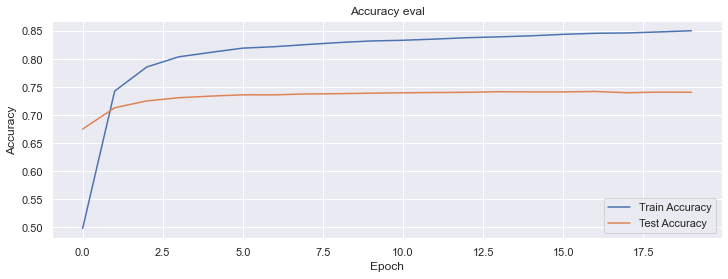

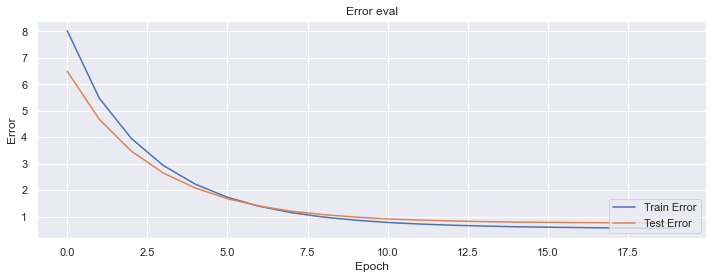

In [186]:
plot_history(history)

In [181]:
model.load_weights('weights.h5')

In [182]:
prob_predictions = model.predict(x_test.toarray())
enc_predictions = np.argmax(predictions, axis = 1)

Accuracy: 0.749
Accuracy (balanced): 0.724


C:\Users\home41_hs\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\home41_hs\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\home41_hs\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

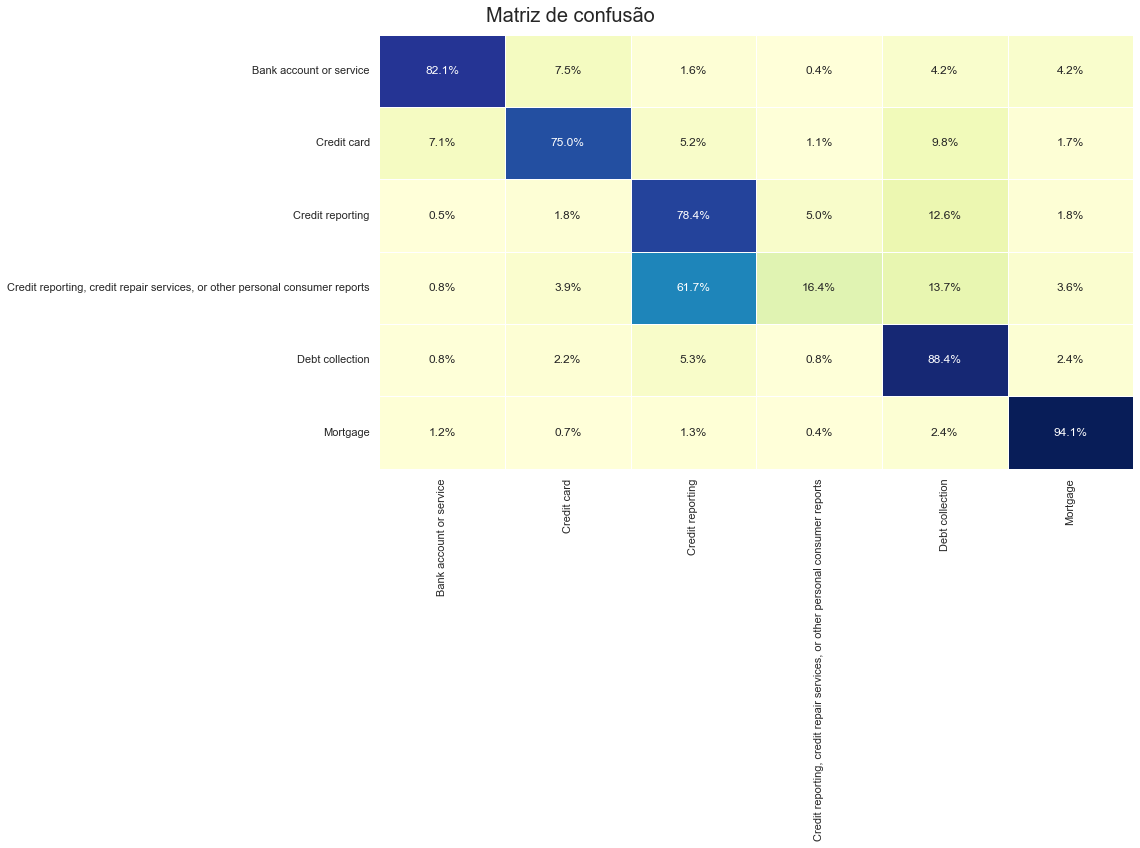

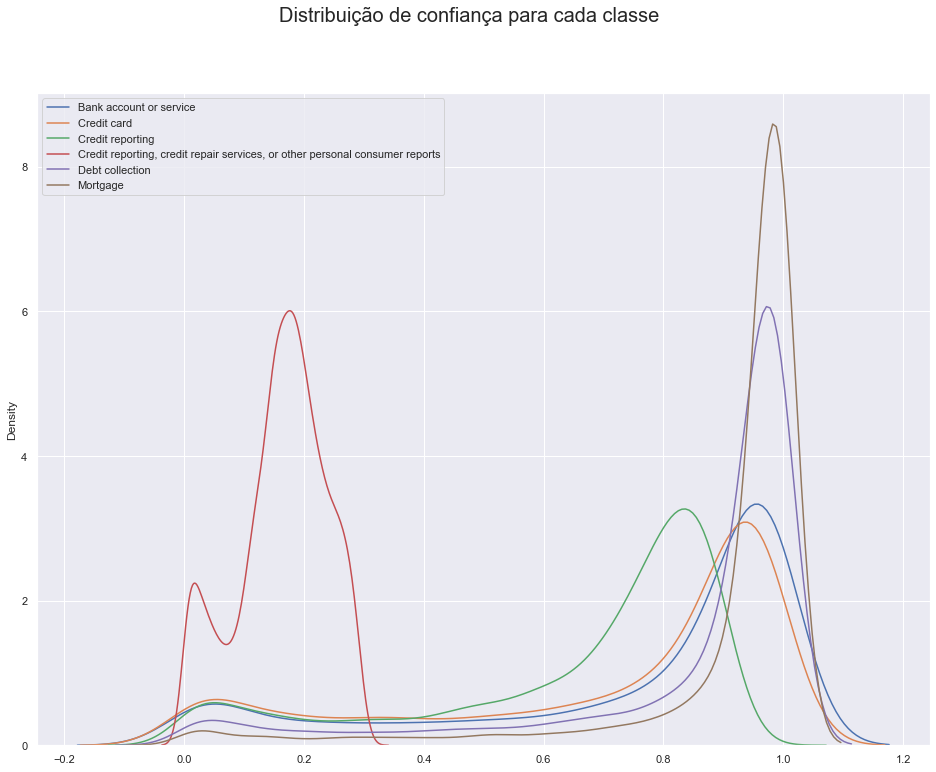

In [183]:
evaluate(ye_test, enc_predictions ,prob_predictions, labels=label_enc.classes_, save = True, save_name='NN_full')

Aparentemente o modelo de Regressão Logística teve um desempenho , generalizando melhor o modelo treinado para os valores do mundo real, porém nesta matérias alguns pontos de atenção como o "design" do formato da rede não foi muito explorado, então esse é pode ser o ponto principal de melhoria na acurácia do modelo de redes